<a href="https://colab.research.google.com/github/AkshitPareek/3D-reconstruction-of-an-object-from-a-Single-Image-and-a-Text-Prompt/blob/main/colab_recon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
IMAGE_NAME = "two.png"
TEXT_PROMPT = "fox"

In [ ]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "SegmentAnything"))
sys.path.append(os.path.join(os.getcwd(), "MCC"))

In [ ]:
import argparse
import copy

import numpy as np
import cv2
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import load_model, load_image, predict, annotate

import supervision as sv

# segment anything
from SegmentAnything.segment_anything import build_sam, SamPredictor 
import matplotlib.pyplot as plt

from tqdm import tqdm

from pytorch3d.io.obj_io import load_obj

import MCC.main_mcc as main_mcc
import MCC.mcc_model as mcc_model
import MCC.util.misc as misc
from MCC.engine_mcc import prepare_data, generate_html

In [ ]:
#Create the COnfig and Pre-Trained Weight path for GroundingDINO
CONFIG_PATH = os.path.join(os.getcwd(), "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(os.getcwd(), "checkpoints", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content/checkpoints/groundingdino_swint_ogc.pth ; exist: True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#loading GroundingDINO
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#loading SAM

sam_checkpoint = 'checkpoints/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

In [ ]:
# IMAGE_NAME = "dog.png"
IMAGE_PATH = os.path.join(os.getcwd(), "input", IMAGE_NAME)

bgr = cv2.imread(IMAGE_PATH)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

In [ ]:
#running GroundingDINO

'''
This Piece of codes selects the object from a text prompt, and generates BoundingBox for SAM
'''

# TEXT_PROMPT = "dog"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


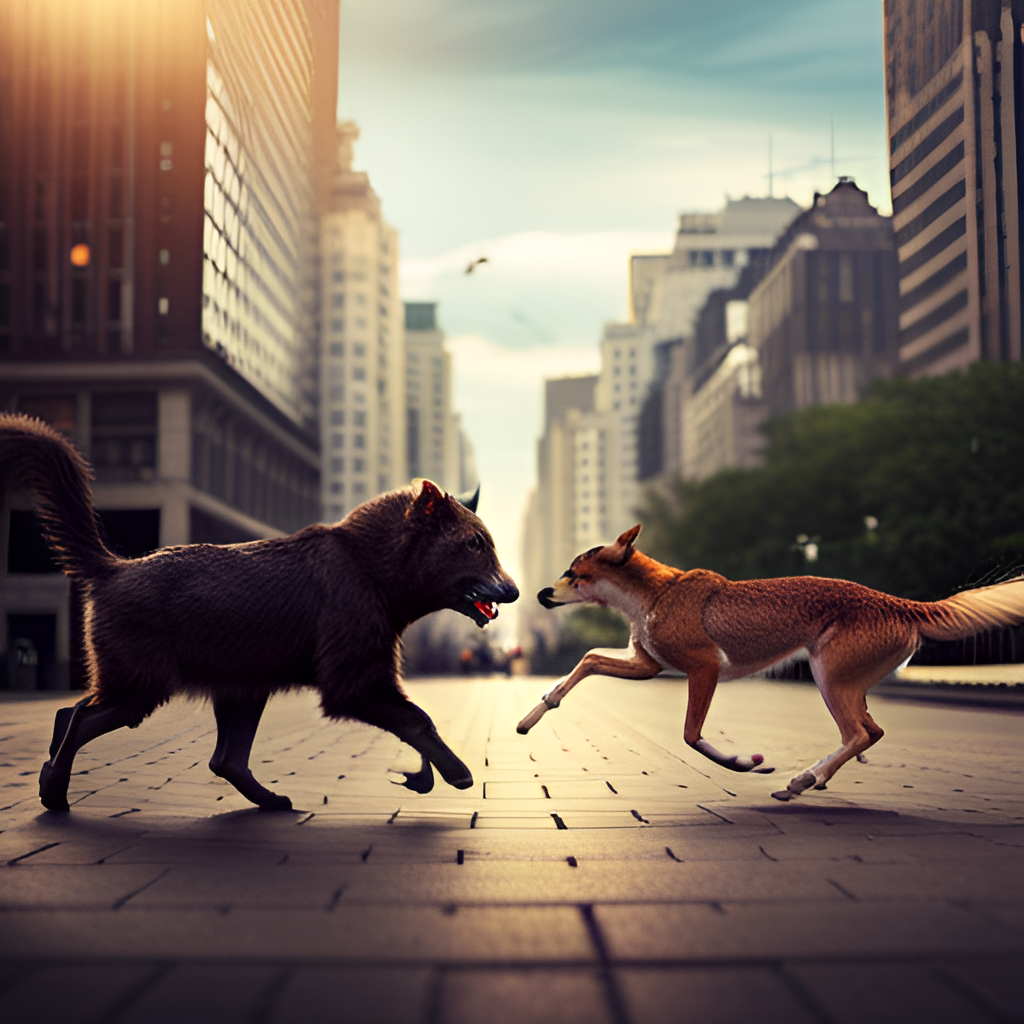

In [ ]:
Image.fromarray(image_source)

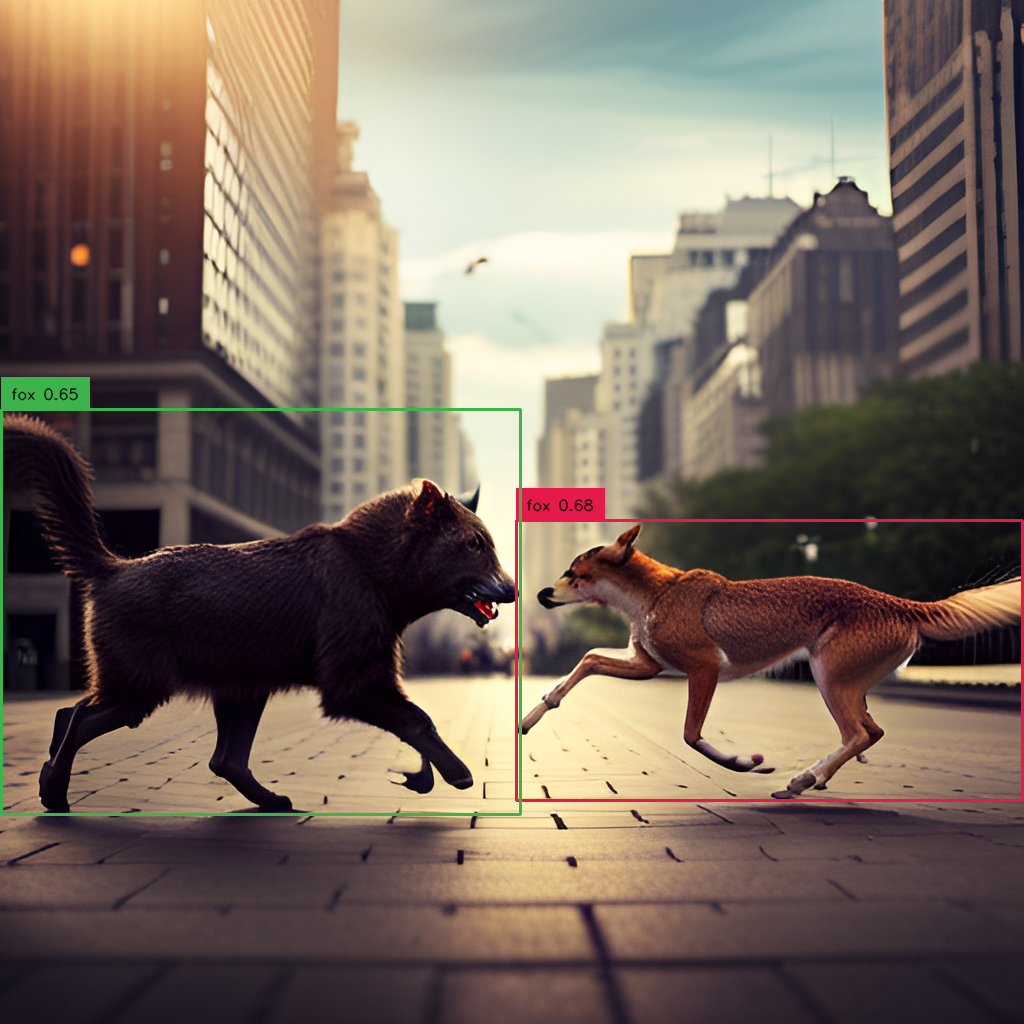